## SGD, SAG and SAGA algorithms

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from numba import njit

ModuleNotFoundError: No module named 'numba'

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We introduce classes that encompass all these information.

In [24]:
class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        return self.X.T @ (self.X @ w - self.y) / self.n + self.lbda * w
    
    def f(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.

    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        return self.X[i] * (self.X[i] @ w - self.y[i]) + self.lbda * w

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L

In [25]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        bAx = self.y * np.dot(self.X, w)
        return  -self.X.T @ (self.y * (1 + np.exp(bAx))**(-1) ) / self.X.shape[0] + self.lbda * w

    def f(self, w):
        bAx = self.y * np.dot(self.X, w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.
    
    def f_i(self,i, w):
        bAx_i = self.y[i] * np.dot(self.X[i], w)
        return np.log(1. + np.exp(- bAx_i)) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        a_i = self.X[i]
        b_i = self.y[i]
        return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, w))) + self.lbda * w


    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Dataset

In [26]:
import scipy.io as sio
mat_contents = sio.loadmat("data_orsay_2017.mat")

X = mat_contents["Xtrain"]
y = mat_contents["ytrain"].flatten()

Xtest = mat_contents["Xtest"]
ytest = mat_contents["ytest"].flatten()

n,d = X.shape

<a id='constant'></a> 

## 3. Implementations


### 3.1 SGD 

In [15]:
def sgd(w0, log_lin,steps, lbda = 0, n_iter=100, cycling = False,
        averaging_on=False, start_late_averaging = 0):
    """Stochastic gradient descent algorithm
    """
    
    model = log_lin(X, y, lbda)
    test_model = log_lin(Xtest,ytest, lbda)
    w_min, obj_min, _ = fmin_l_bfgs_b(model.f, 
                                      w_init, 
                                      model.grad, 
                                      args=(), 
                                      pgtol=1e-30, 
                                      factr =1e-30)
    
    w = w0.copy()
    w_new = w0.copy()
    
    n, d = X.shape
    if not cycling :
        indices = np.random.randint(0, n, n_iter)
    # average x
    w_average = w0.copy()
    # objective history
    objectives = []
    train = []
    # Current objective
    objectives.append(test_model.f(w))
    train.append(model.f(w))
    for k in range(n_iter):
        if cycling :
            i = k % n
        else :
            i = indices[k]
            
        w -= steps[k] * model.grad_i(i, w)
        w = w_new
        ####################################
        # Compute the average iterate
        if k >= start_late_averaging :
               w_average  = (1 - 1 / (k - start_late_averaging + 1) ) * w_average \
                            + 1 / (k - start_late_averaging + 1) * w
        ####################################
        if averaging_on and k >= start_late_averaging:
            w_test = w_average.copy()
        else:
            w_test = w.copy()
         
        if k % 100 == 0 :
            objectives.append(test_model.f(w))
            train.append(model.f(w))
        
    if averaging_on:
        w_output = w_average.copy()
    else:
        w_output = w.copy()    
    return w_output, np.array(objectives)- obj_min, np.array(train)-obj_min

### 3.2 SAG

In [8]:
def sag(w_init, log_lin, step=1., lbda = 0, n_iter=100, store_every=100):
    """Stochastic average gradient algorithm."""
    w = w_init.copy()
    model = log_lin(X, y, lbda)
    test_model = log_lin(Xtest,ytest, lbda)
    w_min, obj_min, _ = fmin_l_bfgs_b(model.f, 
                                      w_init, 
                                      model.grad, 
                                      args=(), 
                                      pgtol=1e-30, 
                                      factr =1e-30)
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    objectives = []
    train = []
    # Current objective
    objectives.append(test_model.f(w))
    train.append(model.f(w))
    for idx in range(n_iter):
        i = indices[idx]
        
        averaged_gradient -= gradient_memory[i]/n
        gradient_memory[i] = model.grad_i(i, w)
        averaged_gradient += gradient_memory[i]/n
        w -= step*averaged_gradient
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            objectives.append(test_model.f(w))
            train.append(model.f(w))
    return w, np.array(objectives)-obj_min, np.array(train)-obj_min

### 3.3 SAGA

In [9]:
def saga(w_init, log_lin, step=1., lbda = 0, n_iter=100, store_every=100):
    """SAGA algorithm."""
    w = w_init.copy()
    model = log_lin(X, y, lbda)
    test_model = log_lin(Xtest,ytest, lbda)
    w_min, obj_min, _ = fmin_l_bfgs_b(model.f, 
                                      w_init, 
                                      model.grad, 
                                      args=(), 
                                      pgtol=1e-30, 
                                      factr =1e-30)
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    objectives = []
    train = []
    # Current objective
    objectives.append(test_model.f(w))
    train.append(model.f(w))
    for idx in range(n_iter):
        i = indices[idx]
        
        new_gradi = model.grad_i(i, w)
        
        w -= step*(new_gradi - gradient_memory[i] + averaged_gradient)
        
        averaged_gradient += (new_gradi - gradient_memory[i])/n
        gradient_memory[i] = new_gradi
        # Update metrics after each iteration.
        if idx % store_every == 0:
            objectives.append(test_model.f(w))
            train.append(model.f(w))
    return w, np.array(objectives)-obj_min, np.array(train)-obj_min

In [10]:
##Setup number of iterations
datapasses = 50  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
niters = int(datapasses * n)
indices = np.random.randint(0, n, niters)

### Comparison

In [13]:
linlog = LinReg #LogReg  #choice of the model : linear regression or logistic regression
mu = 1e-5 #1e-1 # choice of the regularization parameter
w_init = np.zeros(d)

In [21]:
C = 1e-1
steps =list(map(lambda t : C / np.sqrt(t+1), np.arange(niters)) )
w_sgd, obj_sgd, train_sgd = sgd(w_init, linlog, steps, mu, niters)

In [17]:
step = 1e-3
w_sag, obj_sag, train_sag = sag(w_init, linlog, step, mu, niters)

In [18]:
step = 1e-3
w_saga, obj_saga, train_saga = saga(w_init, linlog, step, mu, niters)

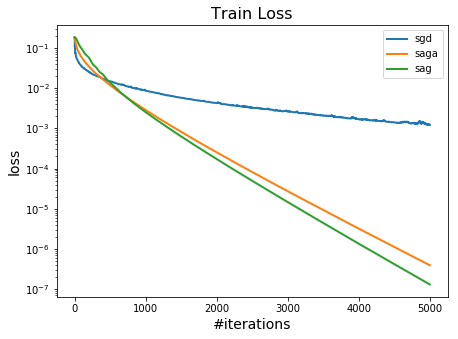

In [22]:
# training loss on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(train_sgd , label="sgd", lw=2)
plt.semilogy(train_saga , label="saga", lw=2)
plt.semilogy(train_sag , label="sag", lw=2)
plt.title("Train Loss", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("train")

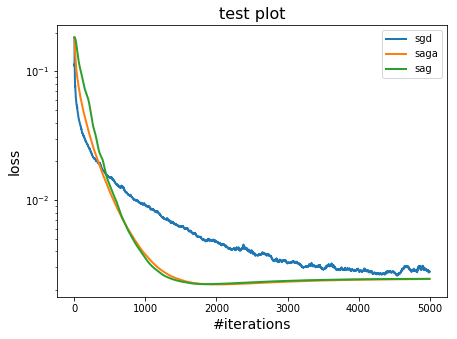

In [23]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgd , label="sgd", lw=2)
plt.semilogy(obj_saga , label="saga", lw=2)
plt.semilogy(obj_sag , label="sag", lw=2)
plt.title("test plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.legend()
plt.savefig("test")